In [1]:
import random
import json
import numpy as np
import pandas as pd
from time import time
import click
import multiprocessing as mp
import matplotlib.pyplot as plt
from deap import algorithms, base, creator, tools

# Problema del viajero (17, 24, 120 ciudades)

In [2]:
def load_cities(n):
    if n not in (17, 24, 120):
        print("Invalid option [17, 24 or 120]. Set to 17")
        n = 17
    
    with open(f"/work/algoritmos_geneticos/Capitulo_2/cities/gr{n}.json", "r") as f:
        tsp = json.load(f)
    return tsp["DistanceMatrix"], tsp["TourSize"]

In [3]:
def gen_individual(size):
    return [random.randint(0, size) for _ in range(size)]

In [4]:
def register_initial_components(n_population=100):
    for _class in ["FitnessMin", "Individual"]:
        if _class in dir(creator):
            delattr(creator, _class)
    
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    # Generación del tour aleatorio
    toolbox.register("indices", random.sample, range(IND_SIZE), IND_SIZE)
    # toolbox.register("indices", gen_individual, IND_SIZE)
    toolbox.register(
        "individual",
        tools.initIterate,
        creator.Individual,
        toolbox.indices
    )
    toolbox.register(
        "population",
        tools.initRepeat,
        list,
        toolbox.individual,
        n_population
    )
    return toolbox

In [5]:
def eval_tsp(individual):
    """Funcion objetivo, calcula la distancia que recorre el viajero"""
    _, counts = np.unique(individual, return_counts=True)
    if not all(counts == 1):
        return 1e6,

    # Distancia entre el último elemento y el primero
    distance = distance_map[individual[-1]][individual[0]]
    # Distancia entre el resto de ciudades
    for gen1, gen2 in zip(individual[:-1], individual[1:]):
        distance += distance_map[gen1][gen2]
    return distance,

In [6]:
# Registro de operaciones géneticas
def register_genetic_operators(toolbox):
    toolbox.register("mate", tools.cxOrdered)
    # toolbox.register("mate", tools.cxOnePoint)
    # toolbox.register("mate", tools.cxPartialyMatched)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=5)
    toolbox.register("evaluate", eval_tsp)

    return toolbox

In [7]:
def simulate(toolbox, CXPB=0.7, MUTPB=0.3, NGEN=45, verbose=False, **kwargs):
    pop = toolbox.population()

    MU, LAMBDA = len(pop), len(pop)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaMuPlusLambda(
        pop,
        toolbox,
        MU,
        LAMBDA,
        CXPB,
        MUTPB,
        NGEN,
        stats=stats,
        halloffame=hof,
        verbose=verbose
    )
    return pop, logbook

In [8]:
def plot_evolution(log):
    gen = log.select("gen")
    fit_mins = log.select("min")
    fit_maxs = log.select("max")
    fit_avg = log.select("avg")

    fig, ax1 = plt.subplots(figsize=(8,8))
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_avg, "--k")
    ax1.fill_between(gen , fit_mins , fit_maxs, facecolor='g', alpha = 0.2)
    ax1.set_title("Minimizar función de Rastrigin mediante algoritmos geneticos")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness")
    # ax1.set_ylim([-1, 240])
    # ax1.set_xlim([0, 51])
    ax1.legend (["Min", "Max", "Avg"], loc="upper right")
    plt.grid(True)

In [9]:
def run(cases):
    random.seed(100)
    results = []
    results_logs = {idx+1: [] for idx in range(len(cases))}
    for idx, case in enumerate(cases):
        toolbox = register_initial_components(case["n_population"])
        toolbox = register_genetic_operators(toolbox)
        for i in range(10):
            t0 = time()
            best, log = simulate(toolbox, **case)
            results.append([idx+1, i, case["n_population"], case["CXPB"],
                case["MUTPB"], case["NGEN"], best[0].fitness.values[0], best[0], round(time()-t0, 4)]
            )
            results_logs[idx+1].append(log)
            print(f"Case {idx+1}: {(i+1)*10}%")

    return pd.DataFrame(results, columns=["Test ID", "Try", "Population", "CXPB", "MUTPB", "NGEN", "Best Fitness", "Best", "Time"]), results_logs

In [10]:
cases = (
    {"n_population": 100, "CXPB": 0.8, "MUTPB":0.2, "NGEN": 50}, # Best to 17
    {"n_population": 200, "CXPB": 0.7, "MUTPB":0.3, "NGEN": 50}, # Best to 24
    # {"n_population": 350, "CXPB": 0.5, "MUTPB":0.5, "NGEN": 200},
    # {"n_population": 350, "CXPB": 0.6, "MUTPB":0.4, "NGEN": 700},
    # {"n_population": 350, "CXPB": 0.7, "MUTPB":0.3, "NGEN": 1000},

)

In [11]:
if __name__ == "__main__":
    distance_map, IND_SIZE = load_cities(24)
    df, logs = run(cases)

Case 1: 10%
Case 1: 20%
Case 1: 30%
Case 1: 40%
Case 1: 50%
Case 1: 60%
Case 1: 70%
Case 1: 80%
Case 1: 90%
Case 1: 100%
Case 2: 10%
Case 2: 20%
Case 2: 30%
Case 2: 40%
Case 2: 50%
Case 2: 60%
Case 2: 70%
Case 2: 80%
Case 2: 90%
Case 2: 100%


In [12]:
df

,Test ID,Try,Population,CXPB,MUTPB,NGEN,Best Fitness,Best,Time
0,1,0,100,0.8,0.2,50,1671.0,"[20, 21, 17, 18, 14, 1, 6, 10, 2, 7, 5, 11, 3,...",1.1206
1,1,1,100,0.8,0.2,50,1593.0,"[5, 6, 10, 15, 0, 11, 3, 8, 12, 22, 4, 20, 7, ...",1.1093
2,1,2,100,0.8,0.2,50,1630.0,"[16, 2, 17, 14, 19, 13, 8, 12, 22, 3, 0, 15, 1...",1.1874
3,1,3,100,0.8,0.2,50,1347.0,"[7, 23, 5, 6, 15, 0, 11, 3, 22, 8, 12, 13, 19,...",1.2035
4,1,4,100,0.8,0.2,50,1393.0,"[3, 11, 0, 15, 5, 23, 7, 6, 10, 2, 16, 17, 21,...",1.1450
5,1,5,100,0.8,0.2,50,1399.0,"[8, 22, 3, 11, 0, 15, 23, 5, 6, 7, 10, 2, 17, ...",1.3128
6,1,6,100,0.8,0.2,50,1559.0,"[1, 18, 14, 17, 21, 20, 4, 23, 11, 22, 12, 8, ...",1.2078
7,1,7,100,0.8,0.2,50,1507.0,"[17, 21, 18, 14, 1, 19, 13, 12, 8, 22, 7, 6, 1...",1.1620
8,1,8,100,0.8,0.2,50,1567.0,"[23, 5, 15, 0, 4, 20, 10, 2, 6, 7, 19, 14, 18,...",1.1750
9,1,9,100,0.8,0.2,50,1435.0,"[6, 23, 5, 15, 0, 3, 11, 7, 20, 4, 22, 8, 12, ...",1.1558


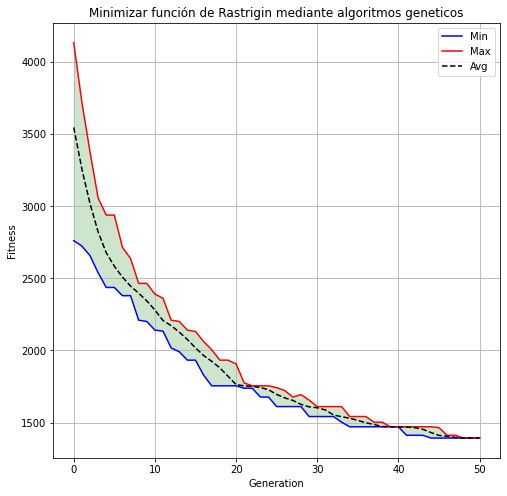

In [13]:
plot_evolution(logs[1][4])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e519ef70-0417-4f93-b18c-a7992756a932' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>